# Financial Model Calibration using ANNs (CaNN, Calibration Neural Network)

##### from "A neural network-based framework for financial model calibration" ([1])

##### Phases:

##### 1. Forward pass (training, prediction)
##### 2. Backward pass (calibration)

# 1) Forward pass




## a) Preperation




In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Updating scipy to use module QMC for Latin hypercube sampling
#!pip install scipy==1.7
from scipy.stats import qmc

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, LinearLR, OneCycleLR, LambdaLR

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
def bs_price_call(S, K, T, t, r, sigma):
  """
  Black-Scholes call option value price related to PDE (2). Returns option's price.
  S: spot price
  K: strike price
  T: time to maturity
  t: spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  # Boundary condition of Black-Sholes PDE (2)
  if T == t:
    return np.maximum(0, S - K)  
  # Solution of the PDE (2) on the open interval [t, T)
  else : 
    d1 = ( np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t) ) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    value = S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2) 
  
  return value

def bs_moneyness_call(moneyness, tau, r, sigma):
  """
  Same function as bs_price_call but in terms of moneyness. Returns V/K and 
  has S/K instead of two seperate paremeters S and K.
  moneyness: S/K
  Tau: time to maturity minus spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  d1 = ( np.log(moneyness) + (r + 0.5 * sigma ** 2) * (tau) ) / (sigma * np.sqrt(tau))
  d2 = d1 - sigma*np.sqrt(tau)
  value_moneyness = moneyness * norm.cdf(d1) - np.exp(-r * (tau)) * norm.cdf(d2) 
  
  return value_moneyness

##### Defining class Heston-IV-ANN

In [24]:
class Heston_ANN(nn.Module):
  def __init__(self):
    """
    Initilize Heston-IV-ANN netwwork with four hidden layers. 
    Same architecture as the one used in Table (2) [1].
    Weight are initialized using Glorot_uniform also known as Xavier_uniform.
    """
    super(Heston_ANN, self).__init__()
    # 4 layers
    self.fc1 = nn.Linear(8, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 200)
    self.fc4 = nn.Linear(200, 200)
    self.fc5 = nn.Linear(200, 1)
    # initilizing the layer's weights
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)


  def forward(self, x):
    """
    Foward pass of the network. 
    Relu activations are used and a linear activation is used in the final layer.
    x: input torch tensor (CUDA or CPU)
    """
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x.flatten()

  def train_model(self, args, device, train_loader, optimizer, epoch):
    """
    Training over train_loader batches for one epoch.
    Returns average training loss.
    args: training parameters.
    device: CUDA or CPU.
    train_loader: train data loader.
    optimizer: gradient descent optmizer.
    epoch: current epoch.
    """
    # train mode
    self.train()
    train_loss = 0
    # loop over data loader
    for batch_idx, data in enumerate(train_loader):
      # extracting the inputs and target
      data, target = data[:,:-1].to(device), data[:,-1].to(device)
      # zeroing the gradients
      optimizer.zero_grad()
      # foward pass
      output = self(data)
      # computing the loss
      loss = F.mse_loss(output, target)
      train_loss += loss.item() * data.shape[0]
      # back propagation
      loss.backward()
      # updating the optimizer step
      optimizer.step()
      # printing batch information
      if batch_idx % args["log_interval"] == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlog Loss: {:.6f}'.format(
            epoch, int(batch_idx / len(train_loader)*len(train_loader.dataset)), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.log(loss.item())))
        if args["dry_run"]:
          break
    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average log loss: {:.4f}\n'.format(np.log(train_loss))) 
    return train_loss


  def test_model(self, device, test_loader):
    """
    Testing over test_loader batches for one epoch. 
    Returns average test loss.
    device: CUDA or CPU.
    test_loader: test data loader.
    """
    # evaluation mode
    self.eval()
    test_loss = 0
    # freezing the gradients
    with torch.no_grad():
      # looping over the test laoder
      for data in test_loader:
        # extracting the inputs and target
        data, target = data[:,:-1].to(device), data[:,-1].to(device)
        # foward pass
        output = self(data)
        #computing the loss
        test_loss += F.mse_loss(output, target, reduction = 'sum').item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(np.log(test_loss))) 
    return test_loss

## b) Numerical method for Data generation

#### COS Method

#### Vanilla call coefficients

$\begin{aligned} \chi_{k}(c, d):=& \frac{1}{1+\left(\frac{k \pi}{b-a}\right)^{2}}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\cos \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right.\\ &\left.+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right] \end{aligned}$

$\psi_{k}(c, d):= \begin{cases}{\left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi},} & k \neq 0, \\ (d-c), & k=0 .\end{cases}$

$V_{k}^{\text {call }}=\frac{2}{b-a} K\left(\chi_{k}(0, b)-\psi_{k}(0, b)\right)$

In [5]:
def call_cosine_coef(a, b, c, d, K, N):
  """
  Coefficient V_k for plain vanilla options. 
  Section 3.1, equations (22) and (23).
  a, b, c, d: truncation range parameters.
  K: Strike.
  N: summing lenght.
  Returns V_k coefficient for call option.
  """
  k = np.arange(N).reshape(1,-1)
  bma    = b - a
  uu     = k * np.pi / bma
  chi_k = 1 / (1 + uu **2 ) * \
  ( np.cos(uu * ( d - a))* np.exp(d) - np.cos(uu * (c - a))* np.exp(c) + uu * np.sin(uu * (d - a)) * np.exp(d)- uu * np.sin(uu*(c-a))* np.exp(c) )
  psi_k = uu
  psi_k[:,1:] = 1 / uu[:,1:] * ( np.sin(uu[:,1:] * ( d - a )) - np.sin( uu[:,1:] * ( c - a) ) )
  psi_k[:,0] = (d - c).flatten() #d - c 
  return 2/bma*K*(chi_k-psi_k)

In [6]:
def call_cosine_coef_moy(a, b, c, d, N):
  """
  Moyeness version.
  Coefficient V_k for plain vanilla options. 
  Section 3.1, equations (22) and (23).
  a, b, c, d: truncation range parameters.
  N: summing lenght.
  Returns V_k coefficient for call option devided by K.
  """
  k = np.arange(N).reshape(1,-1)
  bma    = b - a
  uu     = k * np.pi / bma
  chi_k = 1 / (1 + uu **2 ) * \
  ( np.cos(uu * ( d - a))* np.exp(d) - np.cos(uu * (c - a))* np.exp(c) + uu * np.sin(uu * (d - a)) * np.exp(d)- uu * np.sin(uu*(c-a))* np.exp(c) )
  psi_k = uu
  psi_k[:,1:] = 1 / uu[:,1:] * ( np.sin(uu[:,1:] * ( d - a )) - np.sin( uu[:,1:] * ( c - a) ) )
  psi_k[:,0] = (d - c).flatten() #d - c 
  return 2/bma*(chi_k-psi_k)

#### Charateristic function for Heston model

$\begin{aligned} \varphi_{h e s}\left(\omega ; u_{0}\right)=& \exp \left(i \omega \mu \Delta t+\frac{u_{0}}{\eta^{2}}\left(\frac{1-e^{-D \Delta t}}{1-G e^{-D \Delta t}}\right)(\lambda-i \rho \eta \omega-D)\right) \\ & \cdot \exp \left(\frac{\lambda \bar{u}}{\eta^{2}}\left(\Delta t(\lambda-i \rho \eta \omega-D)-2 \log \left(\frac{1-G e^{-D \Delta t}}{1-G}\right)\right)\right) \end{aligned}$

$D=\sqrt{(\lambda-i \rho \eta \omega)^{2}+\left(\omega^{2}+i \omega\right) \eta^{2}} \quad$ and $\quad G=\frac{\lambda-i \rho \eta \omega-D}{\lambda-i \rho \eta \omega+D} $

In [28]:
def phi_Heston(a ,b ,N ,r, tau, kappa, gamma, vbar, v0, rho):
  """
  Characteristic function of the log-asset price following the Heston model.
  Section 3.3, equation (33).
  a, b: truncation range parameters.
  N: summing lenght.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  Returns Charateristic function vector.
  """
  #if kappa < 1e-5:
  #  kappa = 1e-5
  k = np.arange(N).reshape(1,-1)
  u = np.pi*k/(b-a)
  i = complex(0.0,1.0)
  D = np.sqrt((kappa-gamma*rho*i*u)**2+(u**2+i*u)*gamma**2)
  G = (kappa-gamma*rho*i*u-D)/(kappa-gamma*rho*i*u+D)
  C = v0* (1-np.exp(-D*tau)) / (gamma**2*(1-G*np.exp(-D*tau)))*(kappa-gamma*rho*i*u-D)
  A = r*i*u*tau + kappa*vbar/(gamma**2)*(tau*(kappa-gamma*rho*i*u-D) -2*np.log( (1-G*np.exp(-D*tau))/(1-G) )   ) 
  phi = np.exp( A + C )
  return phi


#### Heston cumulants

$c_{1}=\mu T+\left(1-e^{-\lambda T}\right) \frac{\bar{u}-u_{0}}{2 \lambda}-\frac{1}{2} \bar{u} T$

$\begin{aligned} c_{2}=& \frac{1}{8 \lambda^{3}}\left(\eta T \lambda e^{-\lambda T}\left(u_{0}-\bar{u}\right)(8 \lambda \rho-4 \eta)\right.\\ &+\lambda \rho \eta\left(1-e^{-\lambda T}\right)\left(16 \bar{u}-8 u_{0}\right) \\ &+2 \bar{u} \lambda T\left(-4 \lambda \rho \eta+\eta^{2}+4 \lambda^{2}\right) \\ &+\eta^{2}\left(\left(\bar{u}-2 u_{0}\right) e^{-2 \lambda T}+\bar{u}\left(6 e^{-\lambda T}-7\right)+2 u_{0}\right) \\ &\left.+8 \lambda^{2}\left(u_{0}-\bar{u}\right)\left(1-e^{-\lambda T}\right)\right) \end{aligned}$

In [33]:
def Heston_cumulants( r, tau, kappa, gamma, vbar, v0, rho ):
  """
  Computes Heston cumulants as defined in the appendix A for the Heston model.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  Returns cumulants c1 and c2.
  """

  #if kappa == 0:
  #  c1 = r * tau + tau * (vbar - v0) / 2 - 0.5 * vbar * tau
  #else: 
  #   c1 = r * tau + (1 - np.exp(- kappa * tau)) * (vbar - v0) / (2 * kappa) - 0.5 * vbar * tau
  
  c1 = r * tau + (1 - np.exp(- kappa * tau)) * (vbar - v0) / (2 * kappa) - 0.5 * vbar * tau


  #safe_kappa = np.max(kappa, 1e-5)
  safe_kappa = kappa
  c2 = 0.125 / safe_kappa ** 3 * (gamma * tau * np.exp(- safe_kappa * tau) * (v0 - vbar) * (8 * safe_kappa * rho - 4 * gamma) + \
     safe_kappa * rho * gamma * (1 - np.exp(- safe_kappa * tau)) * (16 * vbar - 8 * v0) + \
     2 * vbar * safe_kappa * tau * (- 4 * safe_kappa * rho * gamma + gamma ** 2 + 4 * safe_kappa ** 2) + \
     gamma ** 2 * ((vbar - 2 * v0) * np.exp(-2 * safe_kappa * tau) + vbar * (6 * np.exp(- safe_kappa * tau) - 7) + 2 * v0) + \
     8 * safe_kappa ** 2 * (v0 - vbar) * (1 - np.exp(-safe_kappa * tau)))
  return c1, c2

#### Truncation range

$[a, b]:=\left[c_{1}-L \sqrt{c_{2}+\sqrt{c_{4}}}, \quad c_{1}+L \sqrt{c_{2}+\sqrt{c_{4}}}\right]$

In [9]:
def Truncation_range(c1, c2, c4, L):
  """
  Computes the truncation range given the cumulants c1, c2, c4 and the truncation lenght L.
  c1, c2, c4: Model cumulants.
  L: truncation lenght.
  Returns tuncation interval sup b and inf a.
  """
  a = c1 - L * np.sqrt( np.abs( c2 ) + np.sqrt( np.abs(c4) ) )
  b = c1 + L * np.sqrt( np.abs( c2 ) + np.sqrt( np.abs(c4) ) ) 
  return a, b

#### Exponential coefficient

$e^{i k \pi \frac{\mathbf{x}-a}{b-a}}$

In [10]:
def exponential_coef(a, b, N, S0, K):
  """
  Computes the exponential coefficient used in the final pricing sum.
  a, b: truncation range.
  N: sum lenght.
  S0: asset initial price.
  K: strike.
  Returns the exponential coefficient vector.
  """
  i = complex(0.0,1.0)
  k = np.arange(N).reshape(1,-1)
  return np.exp(i*k*np.pi*(np.log(S0/K)-a)/(b-a))

In [11]:
def exponential_coef_moy(a, b, N, moyeness):
  """
  Moyeness version.
  Computes the exponential coefficient used in the final pricing sum.
  a, b: truncation range.
  N: sum lenght.
  moyeness: S/K.
  Returns the exponential coefficient vector devided by K.
  """
  i = complex(0.0,1.0)
  k = np.arange(N).reshape(1,-1)
  return np.exp(i*k*np.pi*(np.log(moyeness)-a)/(b-a))

#### Vanilla call price

$v\left(\mathbf{x}, t_{0}, u_{0}\right) \approx \mathbf{K} e^{-r \Delta t} \cdot \operatorname{Re}\left\{\sum_{k=0}^{N-1} \varphi_{h e s}\left(\frac{k \pi}{b-a} ; u_{0}\right) U_{k} \cdot e^{i k \pi \frac{\mathbf{x}-a}{b-a}}\right\}$

In [12]:
def call_option_Heston(N, L, r, tau, kappa, gamma, vbar, v0, rho, K, S0 ):
  """
  Computes call option price using COS method.
  N: sum lenght.
  L: truncation lenght.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  S0: asset initial price.
  K: strike.
  Returns option price.
  """
  c1, c2 = Heston_cumulants( r, tau, kappa, gamma, vbar, v0, rho )
  c4 = 0
  a, b = Truncation_range(c1, c2, c4, L)
  c= 0
  d = b
  V_k = call_cosine_coef(a, b, c, d, K, N)
  phi_k = phi_Heston(a, b, N, r, tau, kappa, gamma, vbar, v0, rho)
  product_k = V_k * phi_k * exponential_coef(a, b, N, S0, K)
  product_k[:,0] = .5 * product_k[:,0]
  return np.exp(-r*tau)*(np.real(  np.sum( product_k,1 )  )).reshape(-1,1)

In [13]:
# cheking the function
N = 500
L= 12
r= .1
tau= 1.4
rho = -0.95
kappa= 1.4
vbar = .1
gamma = .1
v0 = 0.5
K = 100
S0 = 100
# Feller's condition
print(2*kappa*vbar>gamma**2)
call_option_Heston(N = 1500, L= 12, r= r, tau= tau, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, K = K, S0 = S0)

True


array([[29.79261082]])

In [14]:
def call_option_Heston_moy(N, L, r, tau, kappa, gamma, vbar, v0, rho, moyeness ):
  """
  Moyeness version.
  Computes call option price using COS method.
  N: sum lenght.
  L: truncation lenght.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  moyeness: S/K.
  Returns option price.
  """
  c1, c2 = Heston_cumulants( r, tau, kappa, gamma, vbar, v0, rho )
  c4 = 0
  a, b = Truncation_range(c1, c2, c4, L)
  c= 0
  d = b
  V_k = call_cosine_coef_moy(a, b, c, d, N)
  phi_k = phi_Heston(a, b, N, r, tau, kappa, gamma, vbar, v0, rho)
  product_k = V_k * phi_k * exponential_coef_moy(a, b, N, moyeness)
  product_k[:,0] = .5 * product_k[:,0]
  return np.exp(-r*tau)*(np.real(  np.sum( product_k,1 )  )).reshape(-1,1)

In [15]:
# cheking the function
N = 500
L= 12
r= .1
tau= 1.4
rho = -0.95
kappa= 1.4
vbar = .1
gamma = .1
v0 = 0.5
K = 100
S0 = 100
# Feller's condition
print(2*kappa*vbar>gamma**2)
call_option_Heston_moy(N = 1500, L= 12, r= r, tau= tau, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, moyeness = 1)

True


array([[0.29792611]])

# Latin Hypercube Sampling

### Generating Data

#### Sampling range for the Heston parameters (Table (3) in [1])

In [ ]:
# here Table (3) of [1] is used, kappa is numerically sensitive to small values
eps = 1e-2 # is used to generate open intervals
def Heston_LHS_data_generator(n = 10**6, l_bounds = [.6+eps, .05+eps, .0+eps, -0.9+eps, 0.4+eps, .01+eps, .01+eps, .05+eps], u_bounds = [1.4-eps, 3.0-eps, .05-eps, 0.0-eps, 3.0-eps, .5-eps, .8-eps, .5-eps]):
  """
  Generates samples of call prices using Latin hypercube sampling.
  Returns a torch float tensor of dimension (n,9) containig the inputs samples and the value of the call.
  The inputs are: Moyeness (S/K), time to maturity (tau), Risk free rate (r), Correlation (rho), reversion speed (kappa), Long average variance (vbar), Vol of vol (gamma), Initial variance (v0).
  n: number of samples.
  l_bounds: lower bound for the inputs.  
  u_bounds: upper bound for the inputs.
  """
  sampler = qmc.LatinHypercube(d = 8) #, seed = 0
  sample = sampler.random(n)
  sample = qmc.scale(sample, l_bounds, u_bounds)
  indecies = np.argwhere(2*sample[:,4]*sample[:,5] <= sample[:,6]**2)
  sample = np.delete(sample, indecies, 0)
  hs_prices = call_option_Heston_moy(N = 160, L= 12, r= sample[:,2].reshape((-1,1)), tau= sample[:,1].reshape((-1,1)), kappa = sample[:,4].reshape((-1,1)),\
                                     gamma = sample[:,6].reshape((-1,1)), vbar = sample[:,5].reshape((-1,1)), v0 = sample[:,7].reshape((-1,1)),\
                                     rho = sample[:,3].reshape((-1,1)), moyeness = sample[:,0].reshape((-1,1))).reshape((-1,1))
  # hs_prices = call_option_Heston_moy(N = 1500, L= 50, r= sample[:,2].reshape((-1,1)), tau= sample[:,1].reshape((-1,1)), kappa= sample[:,4].reshape((-1,1)),\
  #                                    gamma = sample[:,6].reshape((-1,1)), vbar = sample[:,5].reshape((-1,1)), v0 = sample[:,7].reshape((-1,1)),\
  #                                    rho = sample[:,3].reshape((-1,1)), moyeness = sample[:,0].reshape((-1,1))).reshape((-1,1))

  hs_dataset = np.concatenate((sample, hs_prices),axis=1)

  print("------ INPUT ------")
  print("S/K.......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,0]), max(hs_dataset[:,0])))
  print("Tau.......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,1]), max(hs_dataset[:,1])))
  print("r............ [{:.2f} {:.2f}]".format(min(hs_dataset[:,2]), max(hs_dataset[:,2])))
  print("Corr ........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,3]), max(hs_dataset[:,3])))
  print("Kappa........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,4]), max(hs_dataset[:,4])))
  print("V_bar........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,5]), max(hs_dataset[:,5])))
  print("Gamma........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,6]), max(hs_dataset[:,6])))
  print("V_0 ......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,7]), max(hs_dataset[:,7])))
  print("------ OUTPUT ------")
  print("V/K.......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,-1]), max(hs_dataset[:,-1])))
  # ind_max = np.argmax(hs_dataset[:,-1])
  # print(hs_dataset[ind_max,:])

  return torch.FloatTensor(hs_dataset)

hs_dataset = Heston_LHS_data_generator(10**4)

------ INPUT ------
S/K.......... [0.61 1.39]
Tau.......... [0.06 2.99]
r............ [0.01 0.04]
Corr ........ [-0.89 -0.01]
Kappa........ [0.41 2.99]
V_bar........ [0.02 0.49]
Gamma........ [0.02 0.79]
V_0 ......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.74]


In [ ]:
#eps = 1e-2 # is used to generate open intervals
# (S/K), (tau), (r), (rho), (kappa), (vbar), (gamma), (v0).
# CASE 1 in table 11
#l_bounds = [.75+eps, .4+eps, .0+eps, -0.95+eps, .4+eps, .0+eps, .0+eps, .05+eps]
#u_bounds = [1.25-eps, 1.-eps, .1-eps, 0.0-eps, 2.0-eps, .5-eps, .5-eps, .5-eps]
#hs_dataset = Heston_LHS_data_generator(10**5)

### Training Heston-ANN

In [17]:
# Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 8*10**3,
         "lr": 1e-4,
         "gamma": .5,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])


# Loading Train / Test Data
hs_dataset = Heston_LHS_data_generator(n = 10**5)
train_size, test_size = int(hs_dataset.shape[0]*0.9), int(hs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(hs_dataset, [train_size, hs_dataset.shape[0] - train_size])

train_loader = torch.utils.data.DataLoader(train_dataset, args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])


# Model training
print(device)
model = Heston_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"]) # Adam is found to be the best optimizer in the article
scheduler = StepLR(optimizer, step_size=500, gamma=args["gamma"]) # Deacreses the Learning rate by .5 every 500 epoch

train_losses = []
test_losses = []
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "Heston_ANN_DE.pt")
    

------ INPUT ------
S/K.......... [0.61 1.39]
Tau.......... [0.06 2.99]
r............ [0.01 0.04]
Corr ........ [-0.89 -0.01]
Kappa........ [0.41 2.99]
V_bar........ [0.02 0.49]
Gamma........ [0.02 0.79]
V_0 ......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.76]
cuda
Train Epoch: 1 [0/77496 (0%)]	log Loss: -1.318934

Train set: Average log loss: -3.2420


Test set: Average loss: -4.3059

Current Learning rate 0.0001
Train Epoch: 2 [0/77496 (0%)]	log Loss: -4.277282

Train set: Average log loss: -5.1770


Test set: Average loss: -6.8810

Current Learning rate 0.0001
Train Epoch: 3 [0/77496 (0%)]	log Loss: -6.901868

Train set: Average log loss: -7.3625


Test set: Average loss: -7.6779

Current Learning rate 0.0001
Train Epoch: 4 [0/77496 (0%)]	log Loss: -7.700539

Train set: Average log loss: -7.8956


Test set: Average loss: -8.0749

Current Learning rate 0.0001
Train Epoch: 5 [0/77496 (0%)]	log Loss: -8.088965

Train set: Average log loss: -8.2442


Test set: Average lo

Training WIDE 3.7878901549369034e-07 VS in the article 8.04e-09


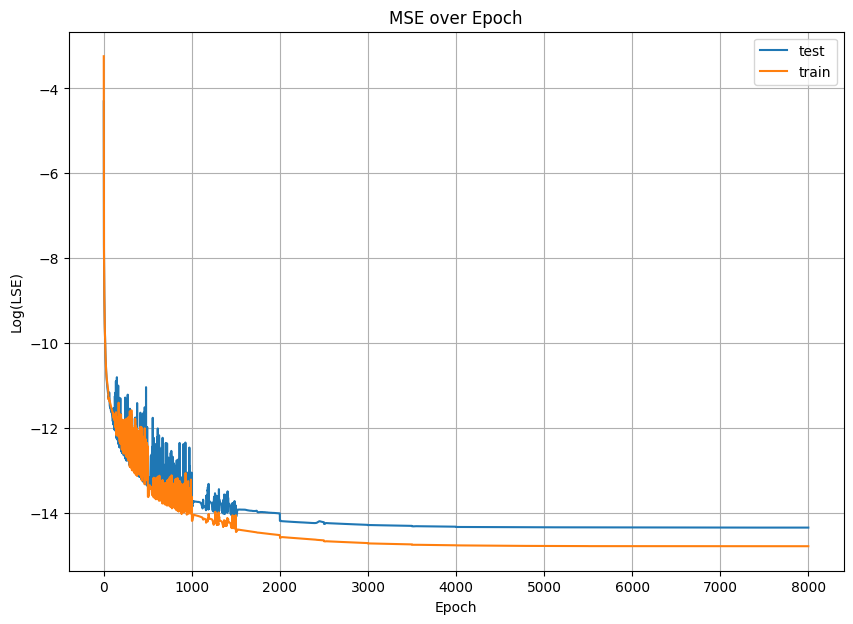

In [18]:
# Plotting log(MSE) as a function of epochs
plt.figure(figsize=(10,7))
plt.plot( np.log(test_losses), label = "test")
plt.plot( np.log(train_losses), label = "train")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(LSE)")
plt.title("MSE over Epoch" )
plt.grid()
print("Training WIDE {} VS in the article 8.04e-09".format(train_losses[-1]) )

## Prediction
#### Load the ANN

In [19]:
# Loading model
device = 'cuda'
loaded_Heston_ANN = Heston_ANN().to(device)
PATH = "ANN_weights/Heston_ANN_DE.pt"
loaded_Heston_ANN.load_state_dict(torch.load(PATH))
loaded_Heston_ANN.eval()


Heston_ANN(
  (fc1): Linear(in_features=8, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=1, bias=True)
)

#### This printed table reproduces the trained forward performance from Table (4) in [1]

In [20]:
# printing train and test erros MSE, MAE, MAPE, R2.
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Train scores----------------
MSE 6.403233e-07
MAE 6.142986e-04
MAPE 2.132194e-02
R2 9.999770e-01
-----------Test scores----------------
MSE 6.388210e-07
MAE 6.101620e-04
MAPE 1.618085e-02
R2 9.999769e-01


#### The ANN Solver can now be used for pricing. (e.g. on data, output = loaded_Heston_ANN(data))

In [21]:
# data loader 
loader = torch.utils.data.DataLoader(hs_dataset, 4048)
# Computing prices
prices = []
with torch.no_grad():
  for data in loader:
    data, _ = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    prices.append((output).data.cpu().numpy())
  prices = np.concatenate(prices)

print(prices)

[0.31377876 0.27277493 0.09332602 ... 0.24409719 0.0850534  0.25261015]


## Calculate implied volatilities

In [37]:
from scipy import optimize

def calcimpliedvol(dataset):
    """
    Computes the implied volatilities using the brent method.
    dataset: numpy array containing moneyness, time to maturity, risk free interest rate and V/K.
    Returns a vector of implied volatilities.
    """
    money = np.array(dataset[0])
    T = np.array(dataset[1])
    r = np.array(dataset[2])
    marketoptionPrice = np.array(dataset[3])
    def bs_price(sigma):
      d1 = ( np.log(money) + (r + 0.5 * sigma ** 2) * (T) ) / (sigma * np.sqrt(T))
      d2 = d1 - sigma*np.sqrt(T)
      value_moyeness = money * norm.cdf(d1) - np.exp(-r * (T)) * norm.cdf(d2) 
      fx = value_moyeness - marketoptionPrice
      return fx
    return optimize.brentq(bs_price,-1,1,maxiter=100)

In [38]:
# data loader 
loader = torch.utils.data.DataLoader(hs_dataset, 4048)
# Computing prices
prices = []
with torch.no_grad():
  for data in loader:
    data, _ = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    prices.append((output).data.cpu().numpy())
  prices = np.concatenate(prices)

# Replace with this
hs_dataset2 = hs_dataset.data[:, np.array([0, 1, 2, 8])]  # Select relevant columns
hs_dataset2[:, 3] = torch.FloatTensor(prices)  # Use Heston-ANN prices as market prices for Brent's method

# Compute implied volatilities using Brent's method
implied_vol = np.apply_along_axis(calcimpliedvol, 1, hs_dataset2)

# Eliminating Nan values
indecies = np.argwhere(np.isnan(implied_vol))
implied_vol = np.delete(implied_vol, indecies, 0)



In [ ]:
print(implied_vol)

# 2) Backward pass

### Reference Hestpn parameter

In [41]:
#Individiual parameters
# 4.1.1 in [1]
T = 2 
S0 = 100
kappa = 0.1
gamma = 0.1  # Volatility of variance
nu_bar = 0.1
rho = -0.75
nu_0 = 0.05
r = 0.05
#"rho": (-0.9, 0.0),         # Correlation coefficient
##   "kappa": (0.1, 3.0),        # Speed of mean reversion
#    "gamma": (0.01, 0.8),      
 #   "nu_0": (0.01, 0.5),        # Initial variance
 #   "nu_bar": (0.01, 0.5)       # Long-term variance

In [ ]:
# Loading model 
device = torch.device("cuda")
loaded_IV_ANN = Heston_ANN().to(device)
PATH = "ANN_weights/IV_SCALED_ANN.pt"
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()


# Plugging in the Heston-ANN prices
hs_dataset2 = hs_dataset.data[:,np.array([0,1,2,8])]
hs_dataset2.data[:,3] = torch.FloatTensor(prices)
loader2 = torch.utils.data.DataLoader(hs_dataset2, 4048)

# Computing IVs
implied_vol = []
indecies_list = []
with torch.no_grad():
  for idx, data in enumerate(loader2):
    data = data.to(device)
    # LOG Transformation
    data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
    data[:,3] = torch.log(data[:,3])
    output = loaded_IV_ANN(data)
    implied_vol.append((output).data.cpu().numpy())
  implied_vol_pipe2 = np.concatenate(implied_vol)

In [ ]:
import numpy as np
import itertools

# Define Heston parameter bounds
bounds = {
    "rho": (-0.9, 0.0),         # Correlation coefficient
    "kappa": (0.1, 3.0),        # Speed of mean reversion
    "gamma": (0.01, 0.8),       # Volatility of variance
    "nu_0": (0.01, 0.5),        # Initial variance
    "nu_bar": (0.01, 0.5)       # Long-term variance
}

# Number of discrete points to sample within each parameter's range
points_per_param = 5

# Generate equally spaced points for each parameter within its bounds
parameter_points = {param: np.linspace(lower, upper, points_per_param)
                    for param, (lower, upper) in bounds.items()}

# Combine the points to form a grid of all possible parameter combinations
grid = list(itertools.product(
    parameter_points["rho"],
    parameter_points["kappa"],
    parameter_points["gamma"],
    parameter_points["nu_0"],
    parameter_points["nu_bar"]
))

# Convert the grid into a NumPy array for convenience
parameter_grid = np.array(grid)

# Display the grid details
print(f"Search space dimensions: {len(parameter_points)} parameters")
print(f"Total combinations: {parameter_grid.shape[0]}")
print("Example combinations (first 5 rows):")
print(parameter_grid[:5])

# Optional: Save to a file for later use
np.savetxt("heston_search_space.csv", parameter_grid, delimiter=",",
           header="rho,kappa,gamma,nu_0,nu_bar", comments="")


In [39]:
import torch
import numpy as np
from scipy.optimize import differential_evolution

def calibrate_with_de(loaded_ANN, moneyness, maturities, r, observed_vols, device="cuda"):
    """
    Calibrates Heston parameters using differential evolution and a trained ANN.
    
    Parameters:
    - loaded_ANN: Trained PyTorch ANN (set to .eval())
    - moneyness: 1D array of moneyness values (e.g., shape (5,))
    - maturities: 1D array of maturities (e.g., shape (7,))
    - r: risk-free rate (scalar)
    - observed_vols: flattened vector of observed implied vols (shape (len(moneyness) * len(maturities),))
    - device: "cuda" or "cpu"
    
    Returns:
    - result.x: optimal Heston parameters [rho, kappa, gamma, nu_bar, nu_0]
    - result.fun: final objective value (MSE)
    """

    # Make sure model is in eval mode
    loaded_ANN.eval()

    # Create full input grid for calibration
    def heston_ann(parameters):
        rho, kappa, gamma, nu_bar, nu_0 = parameters
        inputs = []

        for m in moneyness:
            for t in maturities:
                inputs.append([m, t, r, rho, kappa, nu_bar, gamma, nu_0])

        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)

        with torch.no_grad():
            preds = loaded_ANN(inputs).cpu().numpy().flatten()
        return preds

    # Objective function to minimize
    def calibration_objective(parameters):
        predicted_vols = heston_ann(parameters)
        return np.mean((predicted_vols - observed_vols) ** 2)

    # Bounds for DE (adjust to your actual model/training setup)
    bounds = [
        (-0.9, 0.0),     # rho
        (0.1, 3.0),      # kappa
        (0.01, 0.8),     # gamma
        (0.01, 0.5),     # nu_bar
        (0.01, 0.5),     # nu_0
    ]

    # Run differential evolution
    result = differential_evolution(
        calibration_objective,
        bounds,
        strategy="best1bin",
        popsize=50,
        mutation=(0.5, 1.0),
        recombination=0.7,
        tol=0.001,
        disp=True
    )

    return result.x, result.fun


In [40]:
# Inputs
moneyness = np.linspace(0.85, 1.15, 5)
maturities = np.linspace(0.5, 2.0, 7)
r = 0.03

# Observed vols must be flat vector of shape (35,)
observed_vols = np.linspace(0.2, 0.5, 35)

# Run calibration
opt_params, final_loss = calibrate_with_de(loaded_Heston_ANN, moneyness, maturities, r, observed_vols)

print("Optimal Heston parameters:")
print(f"rho={opt_params[0]:.4f}, kappa={opt_params[1]:.4f}, gamma={opt_params[2]:.4f}, "
      f"nu_bar={opt_params[3]:.4f}, nu_0={opt_params[4]:.4f}")
print(f"Final MSE: {final_loss:.6e}")


differential_evolution step 1: f(x)= 0.00392477
differential_evolution step 2: f(x)= 0.00392477
differential_evolution step 3: f(x)= 0.00379698
differential_evolution step 4: f(x)= 0.00376597
differential_evolution step 5: f(x)= 0.00376597
differential_evolution step 6: f(x)= 0.00376597
differential_evolution step 7: f(x)= 0.0036891
differential_evolution step 8: f(x)= 0.00364717
differential_evolution step 9: f(x)= 0.00364717
differential_evolution step 10: f(x)= 0.00364717
differential_evolution step 11: f(x)= 0.00364717
differential_evolution step 12: f(x)= 0.00364717
differential_evolution step 13: f(x)= 0.00364717
differential_evolution step 14: f(x)= 0.00364717
differential_evolution step 15: f(x)= 0.00364717
differential_evolution step 16: f(x)= 0.00364717
differential_evolution step 17: f(x)= 0.00364717
differential_evolution step 18: f(x)= 0.0036225
differential_evolution step 19: f(x)= 0.0036225
differential_evolution step 20: f(x)= 0.0036225
differential_evolution step 21: f

In [ ]:
import numpy as np

# Observed market implied volatilities (target data)

observed_vols = np.linspace(0.2, 0.5, 35)  # Generates 35 equally spaced values

# Moneyness and time-to-maturity of the observed data
moneyness = np.linspace(0.85, 1.15, 5)  # Moneyness
maturities = np.linspace(0.5, 2.0, 7)   # Time to maturity
r = 0.03
#params = 



# Pre-trained ANN that maps Heston parameters to implied volatilities
def heston_ann(parameters):
    """
    A mock function representing the ANN (pre-trained forward pass).
    In real scenarios, this will return ANN-predicted implied volatilities.
    """
    # Example: Simple mapping for illustration
    rho, kappa, gamma, nu_bar, nu_0 = parameters
    return 0.25 + 0.05 * (moneyness - 1.0) + 0.02 * (maturities - 1.0)

# Objective function for DE calibration
def calibration_objective(parameters):
    """
    Calculates the mean squared error between ANN-predicted
    and observed market volatilities.
    """
    predicted_vols = implied_vol_pipe2
    error = np.mean((predicted_vols - observed_vols) ** 2)
    return error


In [ ]:
bounds = [
    (-0.75, -0.25),   # rho (correlation)
    (0.5, 1.0),    # kappa (mean reversion speed)
    (0.3, 0.5),   # gamma (volatility of variance)
    (0.15, 0.35),   # nu_bar (long-run variance)
    (0.5, 1.0)    # nu_0 (initial variance)
]


In [ ]:
from scipy.optimize import differential_evolution

# Run DE to calibrate the Heston parameters
result = differential_evolution(
    calibration_objective,  # Objective function
    bounds,                 # Parameter bounds
    strategy="best1bin",    # Strategy for mutation
    popsize=50,             # Population size
    mutation=(0.5, 1.0),    # Mutation range
    recombination=0.7,      # Crossover probability
    tol=0.01,               # Convergence tolerance
    disp=True               # Display optimization progress
)

# Display calibrated parameters
print("Calibrated Parameters:", result.x)
print("Objective Function Value:", result.fun)


In [ ]:
# Function to calculate implied volatility using Brent's method
def calc_implied_vol(dataset):
    """
    Computes implied volatilities using the Brent method.
    :param dataset: numpy array containing [S/K, T, r, OptionPrice].
    :return: A single implied volatility value.
    """
    money, T, r, market_price = dataset

    def bs_price(sigma):
        """Black-Scholes option price difference function."""
        d1 = (np.log(money) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        theoretical_price = money * norm.cdf(d1) - np.exp(-r * T) * norm.cdf(d2)
        return theoretical_price - market_price

    # Solve for implied volatility
    try:
        return optimize.brentq(bs_price, 1e-5, 5, maxiter=100)
    except ValueError:
        return np.nan  # Return NaN if Brent fails to converge

# Data generation or loading
hs_dataset = Heston_LHS_data_generator(10**5, l_bounds=l_bounds, u_bounds=u_bounds)
hs_data_loader = DataLoader(hs_dataset, batch_size=4048)

# Step 1: Compute prices using Heston-ANN
predicted_prices = []
with torch.no_grad():
    for data in hs_data_loader:
        inputs = data[:, :-1].to(device)  # Exclude the last column if it's labels
        outputs = loaded_Heston_ANN(inputs)
        predicted_prices.append(outputs.cpu().numpy())
predicted_prices = np.concatenate(predicted_prices)

# Step 2: Prepare the dataset for Brent's method
# Combine predicted prices with necessary inputs for implied volatility calculation
# Assuming hs_dataset.data contains [S/K, T, r, actual_price]:
hs_dataset_data = hs_dataset.data[:, np.array([0, 1, 2])]  # Extract relevant columns
hs_dataset_data = np.hstack((hs_dataset_data, predicted_prices.reshape(-1, 1)))

# Step 3: Calculate implied volatilities
implied_volatilities = np.apply_along_axis(calc_implied_vol, 1, hs_dataset_data)

# Step 4: Evaluate results
# Assuming you have ground-truth implied volatilities for comparison
ground_truth_vol = hs_dataset.data[:, 3]  # Replace with actual column for ground truth
mse = ((ground_truth_vol - implied_volatilities) ** 2).mean()
print(f"MSE: {mse:.6e}")

In [ ]:
# Loading Train / Test Data
hs_dataset = Heston_LHS_data_generator(n = 10**5)
train_size, test_size = int(hs_dataset.shape[0]*0.9), int(hs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(hs_dataset, [train_size, hs_dataset.shape[0]-train_size])
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}
train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])

In [ ]:
# printing train and test erros MSE, MAE, MAPE, R2.
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs, targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs, targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs, targets)) )
print("R2 {:e}".format(r2_score(outputs, targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs, targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs, targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs, targets)) )
print("R2 {:e}".format(r2_score(outputs, targets)) )

In [ ]:
np.sqrt(1.670718e-07)
print("MSE {:e}".format(np.sqrt(1.670718e-07)) )

# FROM HERE THE CODE IS ONLY FOR LOOKBACK PURPOSES

# 5) BRENT

# 6) Pipeline 1: COS + BRENT

In [ ]:
eps = 1e-2 # is used to generate open intervals
# (S/K), (tau), (r), (rho), (kappa), (vbar), (gamma), (v0).
# CASE 1 in table 11
l_bounds = [.75+eps, .4+eps, .0+eps, -0.95+eps, .4+eps, .0+eps, .0+eps, .05+eps]
u_bounds = [1.25-eps, 1.0-eps, .1-eps, 0.0-eps, 2.0-eps, .5-eps, .5-eps, .5-eps]
hs_dataset = Heston_LHS_data_generator(10**5, l_bounds = l_bounds, u_bounds=u_bounds)
hs_dataset_data = hs_dataset.data
hs_dataset_data = hs_dataset_data[:,np.array([0,1,2,8])]
implied_vol_pipe1 = np.apply_along_axis(calcimpliedvol, 1, hs_dataset_data)

# 7) Pipeline 2: Heston-ANN + IV-ANN

In [ ]:
# Loading model
device = torch.device("cuda")
loaded_Heston_ANN = Heston_ANN().to(device)
PATH = "ANN_weights/Heston_ANN.pt"
loaded_Heston_ANN.load_state_dict(torch.load(PATH))
loaded_Heston_ANN.eval()

# data loader 
loader = torch.utils.data.DataLoader(hs_dataset, 4048)
# Computing prices
prices = []
with torch.no_grad():
  for data in loader:
    data, _ = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    prices.append((output).data.cpu().numpy())
  prices = np.concatenate(prices)

# Loading model 
device = torch.device("cuda")
loaded_IV_ANN = IV_ANN().to(device)
PATH = "ANN_weights/IV_SCALED_ANN.pt"
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()


# Plugging in the Heston-ANN prices
hs_dataset2 = hs_dataset.data[:,np.array([0,1,2,8])]
hs_dataset2.data[:,3] = torch.FloatTensor(prices)
loader2 = torch.utils.data.DataLoader(hs_dataset2, 4048)

# Computing IVs
implied_vol = []
indecies_list = []
with torch.no_grad():
  for idx, data in enumerate(loader2):
    data = data.to(device)
    # LOG Transformation
    data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
    data[:,3] = torch.log(data[:,3])
    output = loaded_IV_ANN(data)
    implied_vol.append((output).data.cpu().numpy())
  implied_vol_pipe2 = np.concatenate(implied_vol)
  # indecies_list = np.concatenate(indecies_list).flatten()


In [ ]:
# Eliminating Nan values resulting from prices lower than 1e-7
indecies = np.argwhere(np.isnan(implied_vol_pipe2))
implied_vol_pipe1 = np.delete(implied_vol_pipe1, indecies,0)
implied_vol_pipe2 = np.delete(implied_vol_pipe2, indecies,0)

# 8) Pipeline 1 VS pipeline 2

In [ ]:
# CASE 1
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
outputs = implied_vol_pipe2
targets = implied_vol_pipe1
#targets = vol_imp
print("-----------Vol scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("RMSE {:e}".format(np.sqrt(mean_squared_error(outputs,targets))) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

In [ ]:
# CASE 2
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
outputs = implied_vol_pipe2
targets = implied_vol_pipe1
print("-----------Vol scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("RMSE {:e}".format(np.sqrt(mean_squared_error(outputs,targets))) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

# 9) Volatility surface (COS + IV-ANN)

### Initial volatility surface

In [ ]:
# Generating the surface points
r= .02
tau= 0.5
rho = -0.05
kappa= 1.5
vbar = .1
gamma = .3
v0 = 0.1
moyeness = 0.74
moyeness = np.linspace(moyeness, 1.24,11)
tau = np.linspace(tau, 1, 6)

cos_prices = []
X = []
Y = []
for m in moyeness:
  for t in tau:
    X.append(m)
    Y.append(t)
    cos_prices.append(call_option_Heston_moy(N = 160, L= 12, r= r, tau= t, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, moyeness = m))

In [ ]:
# Reshaping for torch tensor dataset
cos_prices = np.array(cos_prices).reshape((-1, 1))
X = np.array(X).reshape((-1, 1))
Y = np.array(Y).reshape((-1, 1))
r = np.array(r*np.ones(66)).reshape((-1, 1))

In [ ]:
# Creating a torch dataset
data = np.concatenate((X, Y, r, cos_prices), axis = 1)
data = torch.FloatTensor(data)

In [ ]:
# Getting the implied volatility from the dataset
with torch.no_grad():
  data = data.to(device)
  data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
  data[:,3] = torch.log(data[:,3])
  output = loaded_IV_ANN(data)
  bs_IV = (output).data.cpu().numpy()

X = X.flatten()
Y = Y.flatten()
Z = bs_IV

x = np.reshape(X, (-1, 6))
y = np.reshape(Y, (-1, 6))
z = np.reshape(Z, (-1, 6))

In [ ]:
from mpl_toolkits import mplot3d
from matplotlib import cm

In [ ]:
# Plotting the initial volatility surface
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=60)
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', antialiased=True)
ax.set_xlabel('Moyeness')
ax.set_ylabel('Time to matuirity')
ax.set_zlabel('Implied volatility')
plt.show()

### Smoothing the volatility surface

In [ ]:
from scipy import interpolate

In [ ]:
# Smoothing the volatility surface
xnew, ynew = x.copy(), y.copy()
tck = interpolate.bisplrep(x, y, z, s=1.0)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=60)
ax.plot_surface(xnew, ynew, znew,cmap='viridis', edgecolor='none', antialiased=True)
ax.set_xlabel('Moyeness')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Implied volatility')
plt.show()

### Implied volatility difference

In [ ]:
# Generating the surface points
r= .02
tau= 0.5
rho = -0.05
kappa= 1.5
vbar = .1
gamma = .3
v0 = 0.1
moyeness = 0.74
n_moneyness = 11
n_tau = 6
moyeness = np.linspace(moyeness, 1.24,n_moneyness)
tau = np.linspace(tau, 1, n_tau)

cos_prices = []
X = []
Y = []
for m in moyeness:
  for t in tau:
    X.append(m)
    Y.append(t)
    cos_prices.append(call_option_Heston_moy(N = 160, L= 12, r= r, tau= t, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, moyeness = m))

In [ ]:
rho = np.array(rho*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
kappa = np.array(kappa*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
vbar = np.array(vbar*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
gamma = np.array(gamma*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
v0 = np.array(v0*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
# Reshaping for torch tensor dataset
cos_prices = np.array(cos_prices).reshape((-1, 1))
X = np.array(X).reshape((-1, 1))
Y = np.array(Y).reshape((-1, 1))
r = np.array(r*np.ones(n_tau * n_moneyness)).reshape((-1, 1))

In [ ]:
data_ann = np.concatenate((X, Y, r, rho, kappa, vbar, gamma, v0, cos_prices), axis = 1)
data_ann = torch.FloatTensor(data_ann)
# Creating a torch dataset
data = np.concatenate((X, Y, r, cos_prices), axis = 1)
data = torch.FloatTensor(data)

In [ ]:
implied_vol_pipe1 = np.apply_along_axis(calcimpliedvol, 1, data)

In [ ]:
# Getting the implied volatility from the dataset
with torch.no_grad():
  data = data.to(device)
  data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
  data[:,3] = torch.log(data[:,3])
  output = loaded_IV_ANN(data)
  implied_vol_pipe2 = (output).data.cpu().numpy()



In [ ]:
X = X.flatten()
Y = Y.flatten()
Z = (implied_vol_pipe1 - implied_vol_pipe2).flatten()

x = np.reshape(X, (-1, min(n_moneyness, n_tau)))
y = np.reshape(Y, (-1, min(n_moneyness, n_tau)))
z = np.reshape(Z, (-1, min(n_moneyness, n_tau)))

plt.figure(figsize=(8,8))
plt.pcolormesh(x, y, z, shading='gouraud')
plt.colorbar()
plt.xlabel("Moneyness")
plt.ylabel("Time to maturity")
plt.show()

In [ ]:
# Re-import necessary libraries and re-define the setup after reset
from scipy.optimize import differential_evolution
import numpy as np

# Define the objective function
def objective_function(x):
    # Example: A simple quadratic function
    return x[0]**2 + x[1]**2 + x[2]**2

# Define the bounds for each variable
bounds = [(-10, 10), (-10, 10), (-10, 10)]  # Variable bounds for a 3D problem

# Run Differential Evolution with the specified settings
result_custom_de = differential_evolution(
    objective_function,  # Objective function
    bounds,             # Variable bounds
    strategy="best1bin",  # Strategy
    popsize=50,          # Population size
    mutation=(0.5, 1.0), # Mutation range
    recombination=0.7,   # Crossover probability
    tol=0.01,            # Convergence tolerance
    disp=False           # Suppress output during the run
)

# Display the result
result_custom_de
